In [73]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s: %(message)s')

In [74]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchaudio

from tqdm import tqdm
from easydict import EasyDict
import argparse
import yaml
import os
import pdb

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s: %(message)s')

import data
import utils
from models.diffwave_spectrogram import DiffWave as DiffWaveSpec
from models.diffwave_waveform2 import DiffWave as DiffWaveWaveform

from training_utils.diffwave_spectrogram import train_epoch as diffwave_spec_train_epoch, validate as diffwave_spec_validate
from training_utils.diffwave_waveform import train_epoch as diffwave_waveform_train_epoch, validate as diffwave_waveform_validate
from training_utils.diffwave_vocoder import train_epoch as diffwave_vocoder_train_epoch, validate as diffwave_vocoder_validate

In [75]:
MODELS = {'diffwave_spectrogram': DiffWaveSpec, 
          'diffwave_waveform': DiffWaveWaveform,
          'diffwave_vocoder': DiffWaveSpec}
TRAIN_FUNCS = {'diffwave_spectrogram': diffwave_spec_train_epoch,
               'diffwave_waveform': diffwave_waveform_train_epoch,
               'diffwave_vocoder': diffwave_vocoder_train_epoch}
VALIDATE_FUNCS = {'diffwave_spectrogram': diffwave_spec_validate,
                  'diffwave_waveform': diffwave_waveform_validate,
                  'diffwave_vocoder': diffwave_vocoder_validate}


def main(args):
    if not os.path.exists(args.train_dir):
        os.makedirs(args.train_dir)

    summary_writer = SummaryWriter(args.train_dir)
    train_loaders, val_loaders, test_loaders = init_dataloaders(args)
    model_params = load_model_params(args)
    model, optimizer = init_model(model_params, args)
    train_epoch = TRAIN_FUNCS[args.model]
    validate = VALIDATE_FUNCS[args.model]
    model, model_params = train(args,
          model_params,
          model,
          optimizer,
          train_epoch,
          validate,
          train_loaders,
          val_loaders,
          summary_writer)
    
    return model, model_params, train_loaders, val_loaders, test_loaders


def load_model_params(args):
    with open(args.model_params_file, 'r') as f:
        model_params = EasyDict(yaml.load(f, yaml.Loader))
    return model_params


def init_model(model_params, args):
    model = nn.DataParallel(MODELS[args.model](model_params).cuda())
    optimizer = torch.optim.Adam(model.parameters(), args.lr)
    return model, optimizer


def init_dataloaders(args):
    train_dataset = data.MedleyDBSolosDataset(args.dataset_path, instruments=args.instruments, split='training') 
    val_dataset = data.MedleyDBSolosDataset(args.dataset_path, instruments=args.instruments, split='validation') 
    test_dataset = data.MedleyDBSolosDataset(args.dataset_path, instruments=args.instruments, split='test') 

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, drop_last=True, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, drop_last=True, shuffle=False)
    
    train_reverb = data.ReverbDataset(args.rir_path, split='training')
    val_reverb = data.ReverbDataset(args.rir_path, split='validation')
    test_reverb = data.ReverbDataset(args.rir_path, split='test')
    train_reverb_loader = iter(DataLoader(train_reverb, batch_size=args.batch_size))
    val_reverb_loader = iter(DataLoader(val_reverb, batch_size=args.batch_size))
    test_reverb_loader = iter(DataLoader(test_reverb, batch_size=args.batch_size))

    train_noise = data.NoiseDataset(args.noise_path, split='training')
    val_noise = data.NoiseDataset(args.noise_path, split='validation')
    test_noise = data.NoiseDataset(args.noise_path, split='test')
    train_noise_loader = iter(DataLoader(train_noise, batch_size=args.batch_size))
    val_noise_loader = iter(DataLoader(val_noise, batch_size=args.batch_size))
    test_noise_loader = iter(DataLoader(test_noise, batch_size=args.batch_size))

    return (train_loader, train_reverb_loader, train_noise_loader), \
           (val_loader, val_reverb_loader, val_noise_loader), \
           (test_loader, test_reverb_loader, test_noise_loader)


def train(args, 
          model_params,
          model, 
          optimizer, 
          train_epoch,
          validate,
          train_loaders,
          val_loaders,
          summary_writer):
    
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=44100, n_fft=1023, hop_length=256, n_mels=80).cuda()
    global_step = 0 
    for epoch in range(args.epochs):
        logging.info(f'Training epoch {epoch+1}')
        global_step, model, optimizer = train_epoch(global_step, model_params, model, optimizer, train_loaders, summary_writer)

        logging.info(f'Validating epoch {epoch+1}')
        ground_truth, augmented_samples, samples, loss = validate(model_params, model, val_loaders)
        summary_writer.add_scalar('validation/loss', loss, epoch)
        summary_writer.add_audio('sample', samples[0], epoch)
        summary_writer.add_audio('augmented_sample', augmented_samples[0], epoch)
        summary_writer.add_audio('ground_truth', ground_truth[0], epoch)
        summary_writer.add_figure('waveform_sample', utils.plot_waveform(samples[0,0]), epoch)
        summary_writer.add_figure('waveform_augmented_sample', utils.plot_waveform(augmented_samples[0,0]), epoch)
        summary_writer.add_figure('waveform_ground_truth', utils.plot_waveform(ground_truth[0,0]), epoch)
        summary_writer.add_figure('spectrogram_sample', utils.plot_spectrogram(mel_spec_transform(samples)[0,0]), epoch)
        summary_writer.add_figure('spectrogram_augmented_sample', utils.plot_spectrogram(mel_spec_transform(augmented_samples)[0,0]), epoch)
        summary_writer.add_figure('spectrogram_ground_truth', utils.plot_spectrogram(mel_spec_transform(ground_truth)[0,0]), epoch)
        
    return model, model_params

In [76]:
args_spec = EasyDict({'model': 'diffwave_spectrogram',
                 'model_params_file': '/home/code-base/user_space/music_awesomizer/params/diffwave_spectrogram.yml',
                 'train_dir': 'home/code-base/user_space/music_awesomizer/runs/interactive',
                 'epochs': 20,
                 'batch_size': 2,
                 'lr': 2e-4,
                 'instruments': ['piano'],
                 'dataset_path': '/home/code-base/scratch_space/data/medleydb_solos',
                 'rir_path': '/home/code-base/scratch_space/data/audio-awesomizer-production/batch_data/reverb_samples_22050_hz.npz',
                 'noise_path': '/home/code-base/scratch_space/data/audio-awesomizer-production/batch_data/noise_samples_65536_length_22050_hz.npz'})

args_wave = EasyDict({'model': 'diffwave_waveform',
                 'model_params_file': '/home/code-base/user_space/music_awesomizer/params/diffwave_waveform.yml',
                 'train_dir': 'home/code-base/user_space/music_awesomizer/runs/interactive',
                 'epochs': 20,
                 'batch_size': 2,
                 'lr': 2e-4,
                 'instruments': ['piano'],
                 'dataset_path': '/home/code-base/scratch_space/data/medleydb_solos',
                 'rir_path': '/home/code-base/scratch_space/data/audio-awesomizer-production/batch_data/reverb_samples_22050_hz.npz',
                 'noise_path': '/home/code-base/scratch_space/data/audio-awesomizer-production/batch_data/noise_samples_65536_length_22050_hz.npz'})

args_vocoder = EasyDict({'model': 'diffwave_vocoder',
                 'model_params_file': '/home/code-base/user_space/music_awesomizer/params/diffwave_vocoder.yml',
                 'train_dir': 'home/code-base/user_space/music_awesomizer/runs/interactive',
                 'epochs': 20,
                 'batch_size': 2,
                 'lr': 2e-4,
                 'instruments': ['piano'],
                 'dataset_path': '/home/code-base/scratch_space/data/medleydb_solos',
                 'rir_path': '/home/code-base/scratch_space/data/audio-awesomizer-production/batch_data/reverb_samples_22050_hz.npz',
                 'noise_path': '/home/code-base/scratch_space/data/audio-awesomizer-production/batch_data/noise_samples_65536_length_22050_hz.npz'})

In [77]:
train_loaders, val_loaders, test_loaders = init_dataloaders(args_spec)

INFO: 2021-07-23 16:11:52,578: Reading MedleyDB Solos Samples from split training
100%|██████████| 2401/2401 [00:18<00:00, 128.01it/s]
INFO: 2021-07-23 16:12:11,597: Read 2401 music samples
INFO: 2021-07-23 16:12:11,872: Reading MedleyDB Solos Samples from split validation
100%|██████████| 1022/1022 [00:07<00:00, 128.65it/s]
INFO: 2021-07-23 16:12:19,924: Read 1022 music samples
INFO: 2021-07-23 16:12:20,068: Reading MedleyDB Solos Samples from split test
100%|██████████| 2609/2609 [00:20<00:00, 126.69it/s]
INFO: 2021-07-23 16:12:40,945: Read 2609 music samples
INFO: 2021-07-23 16:12:41,243: Batch loading from room impulse response file for split training
INFO: 2021-07-23 16:12:45,509: Read 16000 room impulse response samples
INFO: 2021-07-23 16:12:45,511: Batch loading from room impulse response file for split validation
INFO: 2021-07-23 16:12:46,034: Read 2000 room impulse response samples
INFO: 2021-07-23 16:12:46,035: Batch loading from room impulse response file for split test
INF

In [78]:
spec_model_params = load_model_params(args_spec)
wave_model_params = load_model_params(args_wave)
vocoder_model_params = load_model_params(args_vocoder)

In [79]:
spec_model, _ = init_model(spec_model_params, args_spec)
wave_model, _ = init_model(wave_model_params, args_wave)
vocoder_model, _ = init_model(vocoder_model_params, args_vocoder)

In [80]:
spec_checkpoint_dict = torch.load('/home/code-base/user_space/music_awesomizer/runs/diffwave_spectrogram_trimmed_reverb/checkpoints/checkpoint_500.pt')
wave_checkpoint_dict = torch.load('/home/code-base/user_space/music_awesomizer/runs/diffwave_waveform_correct_reverb_long/checkpoints/checkpoint_4000.pt')
vocoder_checkpoint_dict = torch.load('/home/code-base/user_space/music_awesomizer/runs/diffwave_vocoder_trimmed_reverb/checkpoints/checkpoint_500.pt')

In [81]:
spec_model.load_state_dict(spec_checkpoint_dict['model_state_dict'])
wave_model.load_state_dict(wave_checkpoint_dict['model_state_dict'])
vocoder_model.load_state_dict(vocoder_checkpoint_dict['model_state_dict'])

<All keys matched successfully>

In [82]:
import augmentation
from training_utils.diffwave_spectrogram import generate
import torchaudio

from IPython.display import Audio, display
import matplotlib.pyplot as plt

In [83]:
data_loader, rir_loader, noise_loader = val_loaders
data_loader = iter(data_loader)
eq_model = augmentation.MicrophoneEQ().cuda()
melspec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=spec_model_params.sample_rate,
                                                              n_fft=spec_model_params.n_fft,
                                                              hop_length=spec_model_params.hop_length,
                                                              n_mels=spec_model_params.n_mels).cuda()

In [165]:
x, rir, n = next(data_loader).cuda(), next(rir_loader).cuda(), next(noise_loader).cuda()
clean_x, noisy_x = augmentation.augment(x, rir=rir, noise=n, eq_model=eq_model, nsr_range=[-30,-5])
clean_spectrogram = melspec_transform(clean_x)
noisy_spectrogram = melspec_transform(noisy_x)

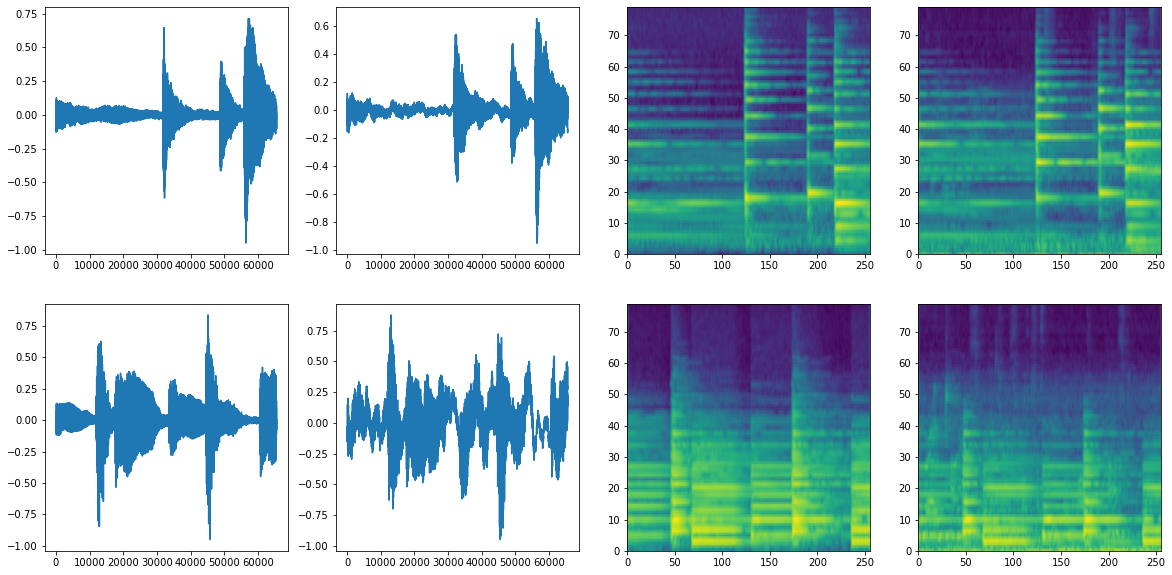

In [166]:
fig, axes = plt.subplots(nrows=clean_x.shape[0], ncols=4, figsize=(20,10))
for i in range(clean_x.shape[0]):
    axes[i,0].plot(clean_x[i,0].detach().cpu().numpy())
    axes[i,1].plot(noisy_x[i,0].detach().cpu().numpy())
    axes[i,2].pcolormesh(clean_spectrogram[i, 0].log2().detach().cpu().numpy(), shading='gouraud')
    axes[i,3].pcolormesh(noisy_spectrogram[i, 0].log2().detach().cpu().numpy(), shading='gouraud')

In [167]:
with torch.no_grad():
    spec_sample = generate(spec_model_params, spec_model, noisy_spectrogram.log2(), t_start=10, t_end=0, init_x=noisy_x)
    spec_sample_spectrogram = melspec_transform(spec_sample)
    
    wave_sample = generate(wave_model_params, wave_model, noisy_x, t_start=49, t_end=0, init_x=noisy_x)
    wave_sample_spectrogram = melspec_transform(wave_sample)
    
    vocoder_sample = generate(vocoder_model_params, vocoder_model, clean_spectrogram.log2(), t_start=49, t_end=0, init_x=noisy_x)
    vocoder_sample_spectrogram = melspec_transform(vocoder_sample)

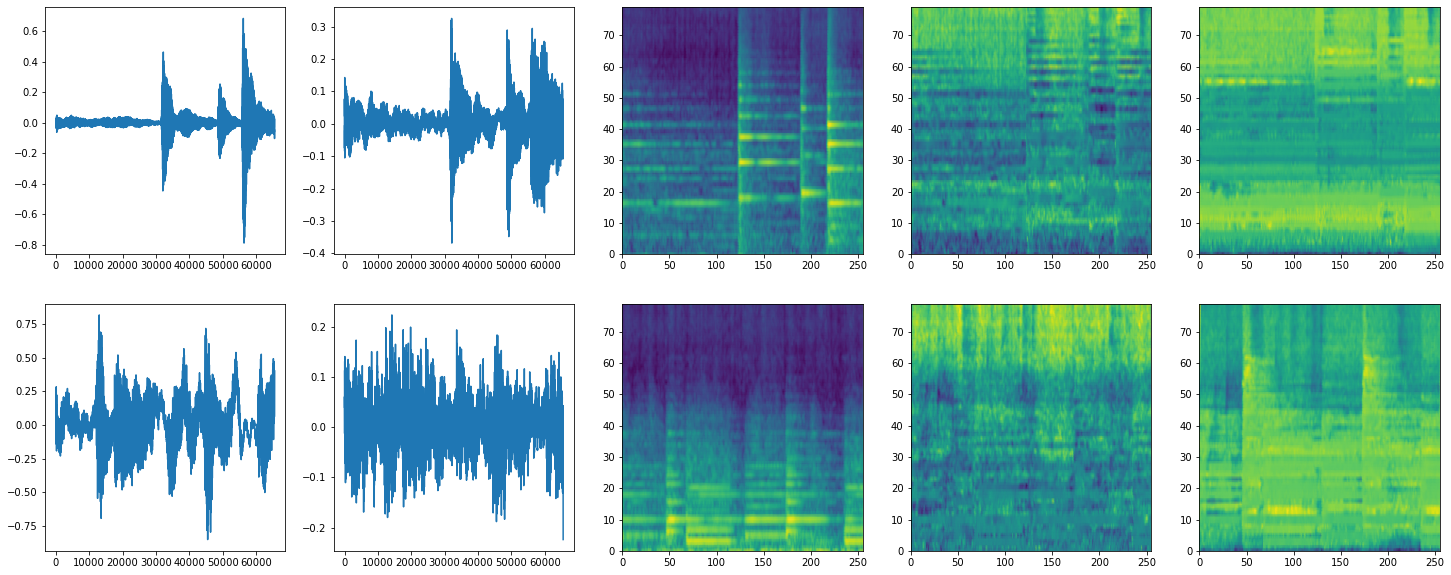

In [168]:
fig, axes = plt.subplots(nrows=spec_sample.shape[0], ncols=5, figsize=(25,5*spec_sample.shape[0]))
for i in range(clean_x.shape[0]):
    axes[i,0].plot(spec_sample[i,0].detach().cpu().numpy())
    axes[i,1].plot((spec_sample[i,0] - noisy_x[i,0]).detach().cpu().numpy())
    axes[i,2].pcolormesh(spec_sample_spectrogram[i, 0].log2().detach().cpu().numpy(), shading='gouraud')
    axes[i,3].pcolormesh((spec_sample_spectrogram[i, 0] / noisy_spectrogram[i, 0]).log2().detach().cpu().numpy(), shading='gouraud')
    axes[i,4].pcolormesh((clean_spectrogram[i, 0] / noisy_spectrogram[i, 0]).log2().detach().cpu().numpy(), shading='gouraud')

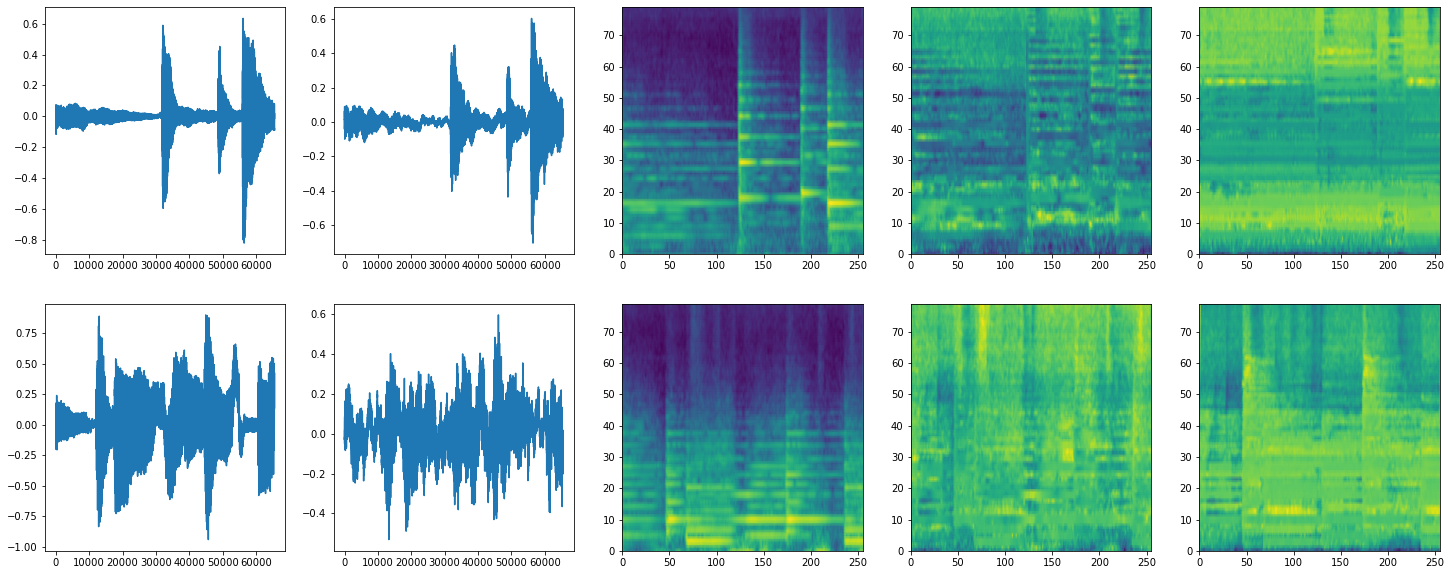

In [169]:
fig, axes = plt.subplots(nrows=wave_sample.shape[0], ncols=5, figsize=(25,5*wave_sample.shape[0]))
for i in range(clean_x.shape[0]):
    axes[i,0].plot(wave_sample[i,0].detach().cpu().numpy())
    axes[i,1].plot((wave_sample[i,0] - noisy_x[i,0]).detach().cpu().numpy())
    axes[i,2].pcolormesh(wave_sample_spectrogram[i, 0].log2().detach().cpu().numpy(), shading='gouraud')
    axes[i,3].pcolormesh((wave_sample_spectrogram[i, 0] / noisy_spectrogram[i, 0]).log2().detach().cpu().numpy(), shading='gouraud')
    axes[i,4].pcolormesh((clean_spectrogram[i, 0] / noisy_spectrogram[i, 0]).log2().detach().cpu().numpy(), shading='gouraud')

In [170]:
for i in range(clean_x.shape[0]):
    display(Audio(clean_x[i,0].detach().cpu().numpy(), rate=22050))

In [171]:
for i in range(clean_x.shape[0]):
    display(Audio(noisy_x[i,0].detach().cpu().numpy(), rate=22050))

In [172]:
for i in range(clean_x.shape[0]):
    display(Audio(spec_sample[i,0].detach().cpu().numpy(), rate=22050))

In [173]:
for i in range(clean_x.shape[0]):
    display(Audio(wave_sample[i,0].detach().cpu().numpy(), rate=22050))

In [174]:
for i in range(clean_x.shape[0]):
    display(Audio(vocoder_sample[i,0].detach().cpu().numpy(), rate=22050))